# 0. Import the necessary libraries

In [1]:
import os
import sys

# Set the working directory to the root directory of the project
project_root = os.path.abspath(os.path.join(os.getcwd(), "../"))
sys.path.append(project_root)

In [2]:
import os
import torch
from src.model.probunet import ProbabilisticUNet
import matplotlib.pyplot as plt

# 1. Create the dataset and dataloaders

In [3]:
from main import load_urytox, create_dataloaders

The device being used is cuda



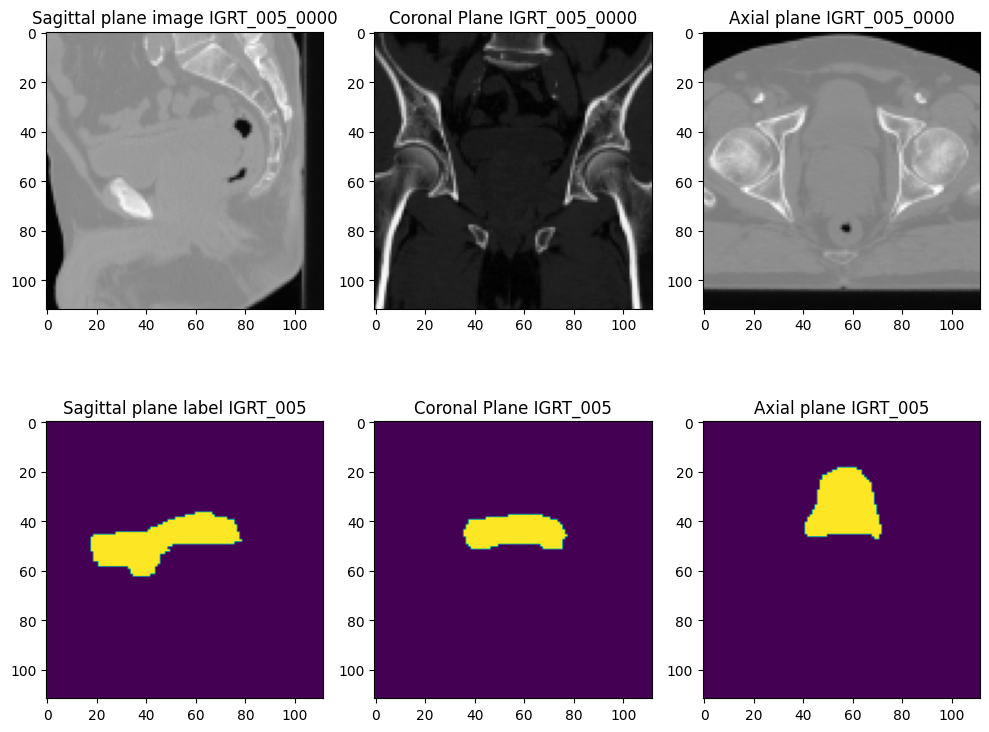

There are 172 pairs of images and labels
The images have shape torch.Size([1, 112, 112, 112])
The labels have shape torch.Size([2, 112, 112, 112])



In [4]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The device being used is {device}\n')

# Set the seeds
seed = torch.Generator().manual_seed(42)

# Load the dataset
dataset = load_urytox(os.path.split(os.getcwd())[0])

# Create the dataloaders
trainloader, validloader, testloader = create_dataloaders(
    dataset, seed, batch_size=1, train_size=0.7)

# 2. Initialize the network and load trained model

In [5]:
model = ProbabilisticUNet(in_channels=1,
                          n_classes=2,
                          latent_dim=6,
                          linear_dim=14 ** 3,
                          unet_factor=2,
                          vae_factor=2,
                          logits=True,
                          is3d=True)

In [6]:
checkpoint_path = os.path.split(os.getcwd())[0] + '/results/trained_models/test_bladder_mean_nologits.pth'

In [7]:
checkpoint = torch.load(checkpoint_path)

In [8]:
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [9]:
model = model.eval()
model = model.to(device)

# 3. Generate 'N' segmentations for the first test batch

In [10]:
image, target, name = next(iter(testloader))
image, target = image.to(device), target.to(device)

In [11]:
# Forward pass to generate the segmentation and initialize the prior
model.forward(image, target, train=False)

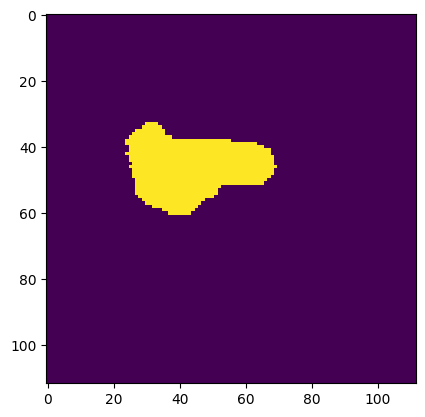

In [12]:
plt.imshow(target.cpu().detach().numpy()[0, 1, :, :, 56])

In [13]:
unet_feats = model.sample()

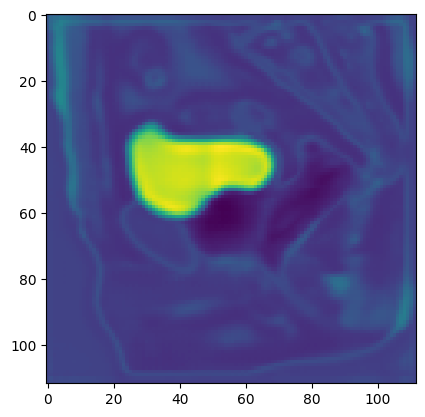

In [14]:
plt.imshow(unet_feats.cpu().detach().numpy()[0][1, :, :, 56])

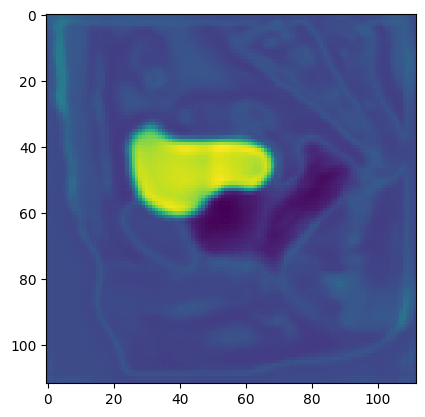

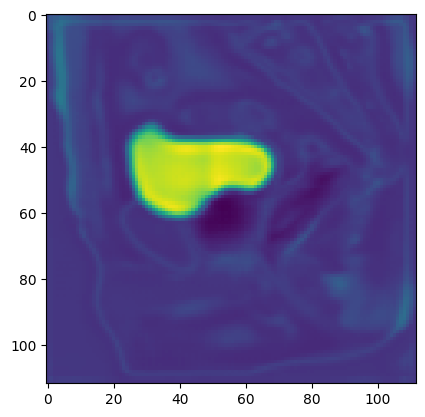

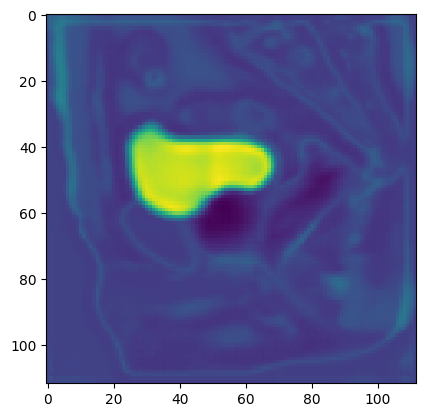

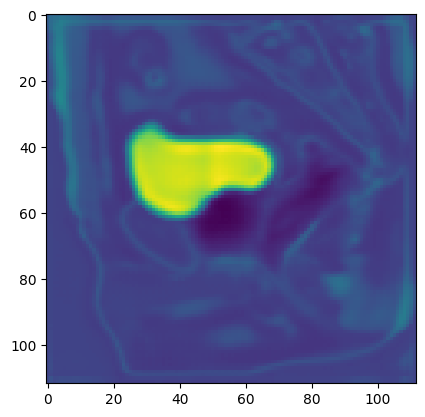

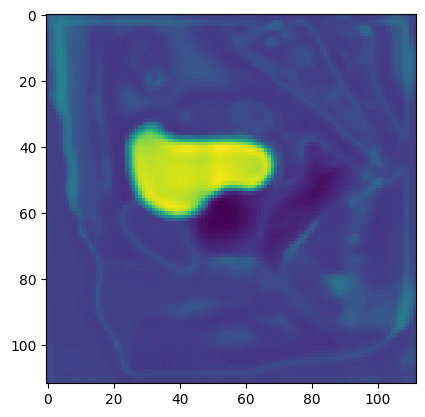

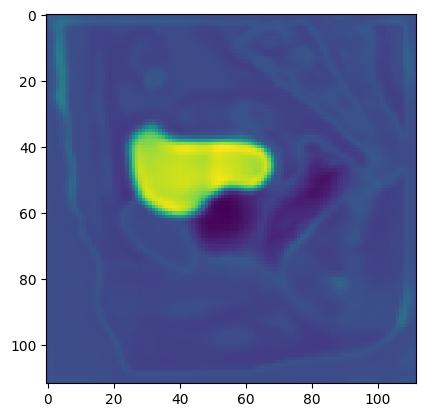

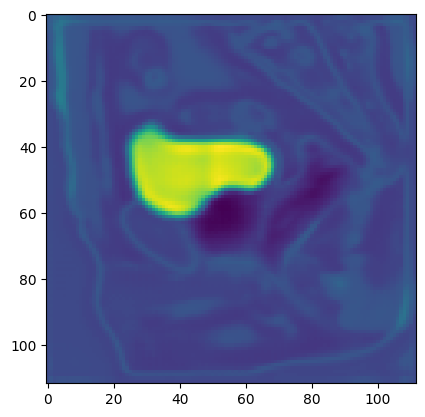

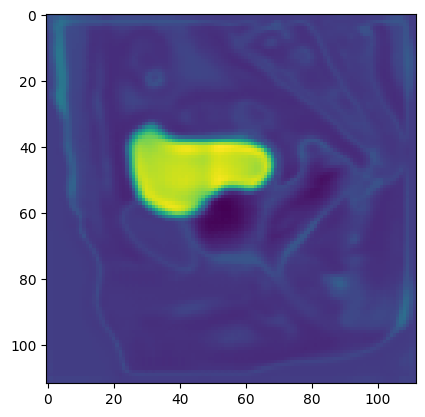

In [15]:
# Example usage
segmentations = []

for i in range(8):
    sample = model.sample(train=False)
    segmentations.append(sample.cpu().detach())
    plt.imshow(sample.cpu().detach().numpy()[0, 1, :, :, 56])
    plt.show()

In [18]:
import torch
import torch.nn.functional as F

# Assuming you have a list of 8 logits tensors named 'logits_list'
# Each tensor has shape [2, 2, 112, 112, 112]

def compute_entropy(logits):
    probabilities = F.softmax(logits, dim=1)  # Convert logits to probabilities
    log_probs = torch.log(probabilities)
    entropy = -torch.sum(probabilities * log_probs, dim=1)  # Compute pixelwise entropy
    return entropy

def compute_uncertainty_map(logits_list):
    num_images = len(logits_list)
    spatial_dim = logits_list[0].shape[2:]
    uncertainty_map = torch.zeros(spatial_dim)  # Initialize uncertainty map

    for i in range(num_images):
        for j in range(num_images):
            if i != j:
                entropy = compute_entropy(logits_list[i] - logits_list[j])  # Compute entropy between images
                uncertainty_map += entropy.sum(dim=0)  # Sum the entropy along the batch dimension

    return uncertainty_map / (num_images * (num_images - 1))  # Normalize the uncertainty map

# Example usage
uncertainty_map = compute_uncertainty_map(segmentations)


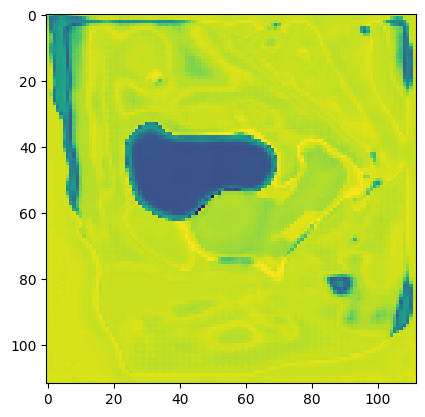

In [19]:
plt.imshow(uncertainty_map[:, :, 56])

def plot_segmentations(sampled_seg, target):
    """
    Plots 'n' segmentations side by side along with the target segmentation.

    Parameters
    ----------
    sampled_seg : torch.Tensor
        Probabilistic segmentations to plot.
    target : torch.Tensor
        Target segmentation to plot.
    """

    n = sampled_seg.shape[0]  # Number of segmentations

    # Create subplots for each segmentation
    fig, axes = plt.subplots(1, n+1, figsize=((n+1)*5, 5))

    # Plot the target segmentation
    axes[0].imshow(target.cpu().detach().numpy()[0][1], cmap='gray')
    axes[0].set_title('Target')
    axes[0].axis('off')

    # Iterate over the sampled segmentations and plot them
    for i in range(n):
        seg = sampled_seg[i][0][1]  # Get the segmentation
        axes[i+1].imshow(seg, cmap='gray')  # Plot the segmentation
        axes[i+1].set_title(f'Sample {i+1}')
        axes[i+1].axis('off')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()  # Display the plot


plot_segmentations(segmentations.cpu().detach().numpy(), target)